In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [59]:
df = pd.read_csv("../data/raw/exchangeRateIATA.csv", sep=";")
df["dates"] = pd.to_datetime(df["dates"])

## EDA

In [64]:
df.head()

,dates,iata
0,2017-01-01,672
1,2017-01-02,672
2,2017-01-03,670
3,2017-01-04,675
4,2017-01-05,674


In [141]:
df.dates.min()

Timestamp('2017-01-01 00:00:00')

In [142]:
df.dates.max()

Timestamp('2024-10-24 00:00:00')

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2854 entries, 0 to 2853
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dates   2854 non-null   datetime64[ns]
 1   iata    2854 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 44.7 KB


**No hay valores nulos**

In [66]:
df.describe()

,dates,iata
count,2854,2854.000000
mean,2020-11-27 12:00:00,771.534688
min,2017-01-01 00:00:00,590.000000
25%,2018-12-15 06:00:00,675.000000
50%,2020-11-27 12:00:00,776.000000
75%,2022-11-10 18:00:00,851.000000
max,2024-10-24 00:00:00,1051.000000
std,NaN,105.123205


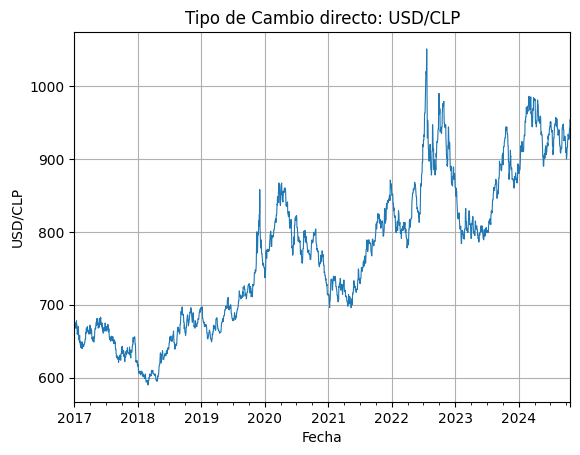

In [80]:
df.plot(
    x="dates",
    y="iata",
    title="Tipo de Cambio directo: USD/CLP",
    xlabel="Fecha",
    ylabel="USD/CLP",
    grid=True,
    legend=False,
    linewidth=0.8
    #ylim=(0,1200)
)
plt.show()

In [111]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df["iata"].dropna())

print(f"Rechaza H0 (serie no estacionaria): {pvalue < 0.05}")

Rechaza H0 (serie no estacionaria): False


## Eliminación de Tendencia

$$\Delta ln(USD\_CLP_{t}) \equiv ln(USD\_CLP_{t}) - ln(USD\_CLP_{t-1})$$

In [69]:
df["diff_1"] = np.log(df["iata"]) - np.log(df["iata"].shift())

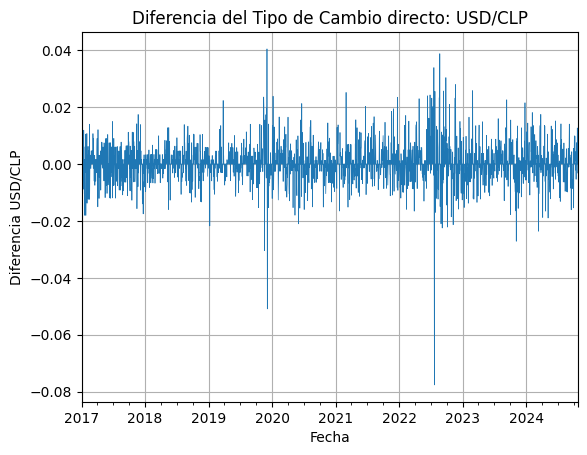

In [89]:
df.plot(
    x="dates",
    y="diff_1",
    title="Diferencia del Tipo de Cambio directo: USD/CLP",
    xlabel="Fecha",
    ylabel="Diferencia USD/CLP",
    grid=True,
    legend=False,
    linewidth=.5,
)
plt.show()

In [110]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df["diff_1"].dropna())

print(f"Rechaza H0 (serie no estacionaria): {pvalue < 0.05}")

Rechaza H0 (serie no estacionaria): True


Se requiere 1 grado de diferenciación para que la serie sea estacionaria.

## Definición de Benchmarks



### Determinación de los Rezagos AR(p)

#### Función de Autocorrelación Parcial (PACF)

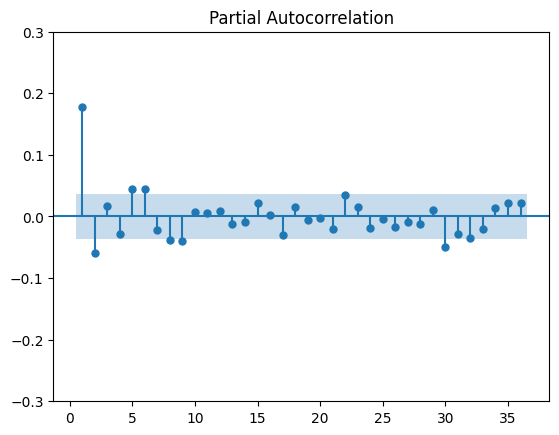

In [140]:
plot_pacf(df["diff_1"].dropna(), lags=36, method="ywm", zero=False)
plt.ylim(-.3,.3)
plt.show()

Dada la inspección visual del gráfico de autocorrelacion parcial, se determina que la componente autoregresiva será de orden 1 y 2. Si bien los rezagos 5, 6, 8, 9 y 30 sobrepasan la banda de significancia, estos carecen de sentido económico, por lo que son descartados.

### Determinación de los Rezagos MA(q)

#### Función de Autocorrelación (ACF)

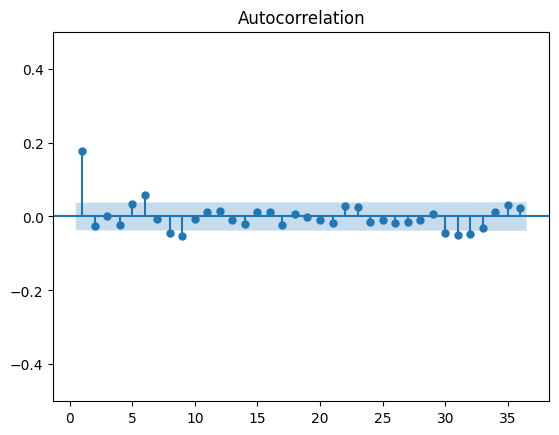

In [138]:
plot_acf(df["diff_1"].dropna(), lags=36, zero=False)
plt.ylim(-.5,.5)
plt.show()

Dada la inspección visual del gráfico de autocorrelacion, se determina que la componente de media móvil será de orden 1. Al igual que en la func